In [1]:
import json
import pathlib
import pickle
import re

import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
from matplotlib import pyplot as plt

from labm8 import humanize

import numpy as np
import pandas as pd
import tensorflow as tf
from labm8 import app
from labm8 import app
from labm8 import app
from graph_nets.demos import models as gn_models
from graph_nets import utils_np as graph_net_utils_np

from deeplearning.deeptune.opencl.heterogeneous_mapping import utils
from deeplearning.deeptune.opencl.heterogeneous_mapping.models import models
from labm8 import prof
from labm8 import viz

flags.FLAGS(['argv[0]'])

%matplotlib inline

/home/cec/.cache/bazel/_bazel_cec/d1665aef25bbeeb91c01df7ddc90dba7/execroot/phd/bazel-out/k8-opt/bin/docs/wip_graph/notebooks/notebooks.runfiles/pypi__h5py_2_7_1/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Read experimental data

In [2]:
def ReadTelemetryFiles(outdir: pathlib.Path, group: str):
    outdir = pathlib.Path(outdir)
    if not (outdir / 'telemetry').is_dir():
        return []
    logs = []
    for json_file in (outdir / 'telemetry').iterdir():
        with open(json_file) as f:
            log = json.load(f)
        logs.append(log)
        log['group'] = group
    return logs

telemetries = (
    ReadTelemetryFiles('/var/phd/shared/docs/wip_graph/1548865189.cc2/reachability/lstm/linux_ocl', 'Successors') +
    ReadTelemetryFiles('/var/phd/shared/docs/wip_graph/1548865432.cc2/reachability/lstm_neighbors_only/linux_ocl', 'Neighbors') +
[])
assert telemetries

df = pd.DataFrame(telemetries).sort_values(by=['group', 'epoch'])
df.shape

(87, 15)

## Results Overview

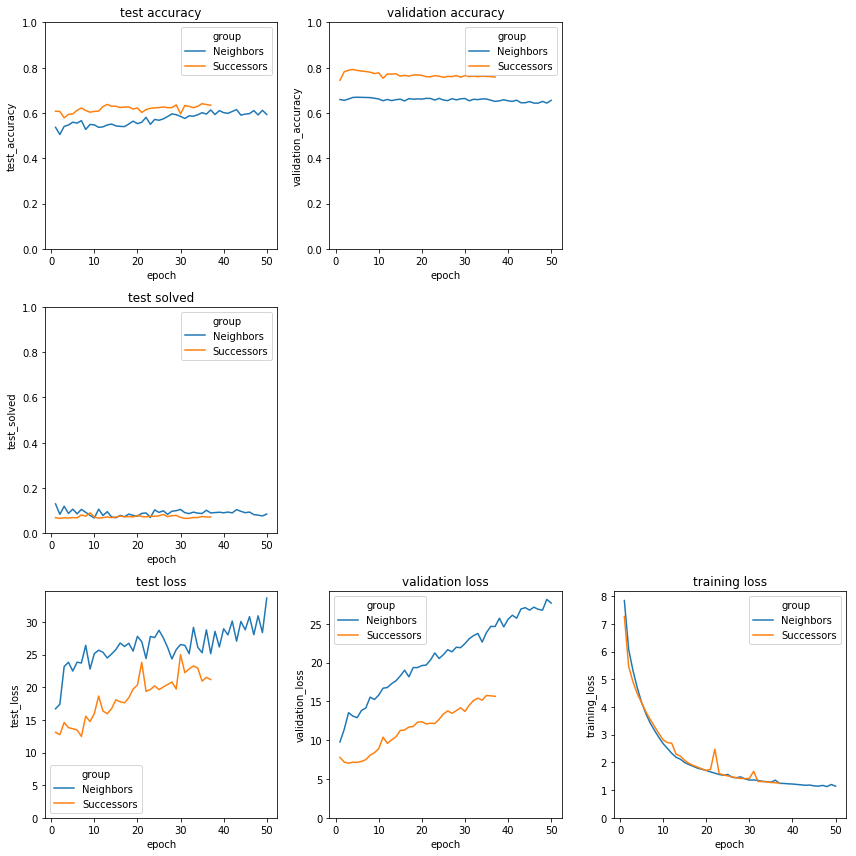

In [14]:
def PlotOverview(df, scale_axis: bool = True):
    fig = plt.figure(figsize=(12, 12))
    fig.clf()

    for j, row in enumerate(['test', 'validation', 'training']):
        if f'{row}_accuracy' in df.columns:
            ax = fig.add_subplot(3, 3, j + 1)
            sns.lineplot('epoch', f'{row}_accuracy', hue='group', data=df, ax=ax)
            ax.set_ylim((0, 1) if scale_axis else (None, None))
            ax.set_title(f'{row} accuracy')

        if f'{row}_solved' in df.columns:
            ax = fig.add_subplot(3, 3, j + 4)
            sns.lineplot('epoch', f'{row}_solved', hue='group', data=df, ax=ax)
            ax.set_ylim((0, 1) if scale_axis else (None, None))
            ax.set_title(f'{row} solved')

        if f'{row}_loss' in df.columns:
            ax = fig.add_subplot(3, 3, j + 7)
            sns.lineplot('epoch', f'{row}_loss', hue='group', data=df, ax=ax)
            ax.set_ylim((0, None) if scale_axis else (None, None))
            ax.set_title(f'{row} loss')

    viz.finalise()
    
PlotOverview(df, scale_axis=True)

### Loss

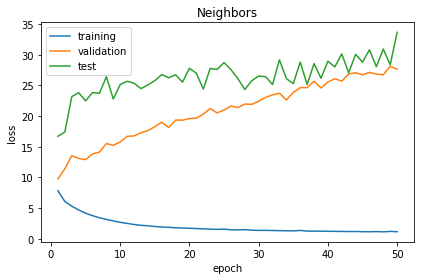

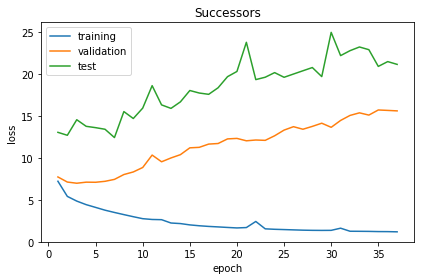

In [10]:
def TableOfAllTrainingLosses(df: pd.DataFrame):
    losses = []
    for _, row in df.iterrows():
        for loss in row['training_losses']:
            losses.append({
                'epoch': row['epoch'],
                'group': row['group'],
                'loss': loss,
            })
    return pd.DataFrame(losses)

groups = sorted(set(df['group']))
for i, group in enumerate(groups):
    df_to_plot = df[df['group'] == group]
    if 'training_losses' in df.columns:
        sns.lineplot('epoch', 'loss', data=TableOfAllTrainingLosses(df_to_plot), label='training')
    else:
        sns.lineplot('epoch', 'training_loss', data=df_to_plot, label='training')
    sns.lineplot('epoch', 'validation_loss', data=df_to_plot, label='validation')
    sns.lineplot('epoch', 'test_loss', data=df_to_plot, label='test')
    plt.ylabel('loss')
    plt.legend()
    plt.title(group)
    viz.finalise()

### Accuracy

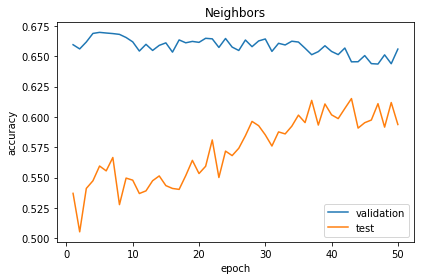

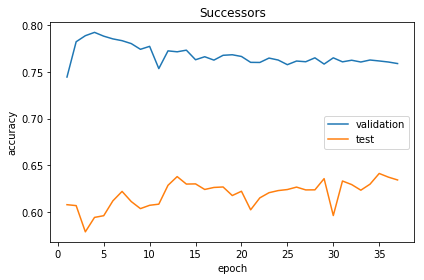

In [11]:
groups = sorted(set(df['group']))
for i, group in enumerate(groups):
    df_to_plot = df[df['group'] == group]
    if 'training_accuracy' in df_to_plot.columns:
        sns.lineplot('epoch', 'training_accuracy', data=df_to_plot, label='training')
    if 'validation_accuracy' in df_to_plot.columns:
        sns.lineplot('epoch', 'validation_accuracy', data=df_to_plot, label='validation')
    if 'test_accuracy' in df_to_plot.columns:
        sns.lineplot('epoch', 'test_accuracy', data=df_to_plot, label='test')
    plt.ylabel('accuracy')
    plt.title(group)
    viz.finalise()

## Solved

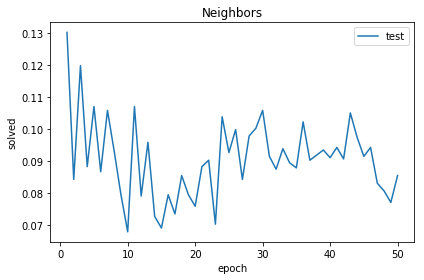

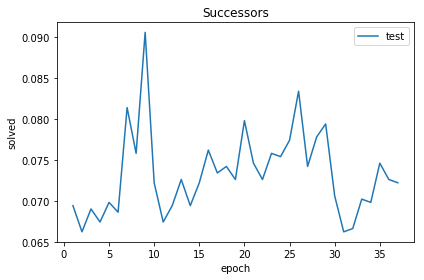

In [12]:
groups = sorted(set(df['group']))
for i, group in enumerate(groups):
    df_to_plot = df[df['group'] == group]
    if 'training_solved' in df_to_plot:
        sns.lineplot('epoch', 'training_solved', data=df_to_plot, label='training')
    if 'validation_solved' in df_to_plot:
        sns.lineplot('epoch', 'validation_solved', data=df_to_plot, label='validation')
    if 'test_solved' in df_to_plot:
        sns.lineplot('epoch', 'test_solved', data=df_to_plot, label='test')
    plt.ylabel('solved')
    plt.title(group)
    viz.finalise()

In [13]:
# Epoch with highest accuracy on the validation set.
groups = sorted(set(df['group']))

rows = []
for i, group in enumerate(groups):
    group_df = df[df['group'] == group]
    idxmax = group_df['validation_accuracy'].idxmax()
    best_result = group_df.loc[idxmax]
    training_graphs = best_result['training_graph_count'] // best_result['num_classes']
    validation_graphs = best_result['validation_graph_count'] // best_result['num_classes']
    test_graphs = best_result['test_graph_count'] // best_result['num_classes']
    rows.append({
        'Group': group,
        'Epoch #': f"{best_result['epoch']} / {group_df['epoch'].max()}",
        'Validation accuracy': f"{best_result['validation_accuracy']:.2%}",
        'Test accuracy': f"{best_result['test_accuracy']:.2%} ({group_df['test_accuracy'].max():.2%})",
        'Test solved': f"{best_result['test_solved']:.2%} ({group_df['test_solved'].max():.2%})",
        'Train / val / test size': f"{training_graphs} / {validation_graphs} / {test_graphs}"
    })
pd.DataFrame(rows, columns=['Group', 'Epoch #', 'Validation accuracy', 'Test accuracy', 'Test solved', 'Train / val / test size'])

,Group,Epoch #,Validation accuracy,Test accuracy,Test solved,Train / val / test size
0,Neighbors,5 / 50,66.97%,55.95% (61.51%),10.70% (13.01%),2000 / 850 / 2505
1,Successors,4 / 37,79.23%,59.44% (64.14%),6.75% (9.06%),2000 / 850 / 2505
